## Vehicle Detection and Tracking using HOG + SVM

Here we will train a SVM classifier that uses HOG features and other traditional techniques to detect Vehicles in a video.

In [1]:
import glob
import os
import numpy as np
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from imp import reload

# To display pd.DataFrames beautifully
from IPython.display import display, HTML

# display plot in the notebook
%matplotlib inline

# reload feature_extractor
import feature_extractor
reload(feature_extractor); from feature_extractor import FeatureExtractor

# reload car_finder
import car_finder
reload(car_finder); from car_finder import CarFinder

### Configurations

In [2]:
# Configurations - Tweak these parameters to fine tune results.
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

# feature_extractor
feature_extractor = FeatureExtractor()

### Artifacts Folder

In [3]:
# artifacts folder
GEN_FOLDER = '../gen'
if not os.path.exists(GEN_FOLDER):
    os.makedirs(GEN_FOLDER)
    print("artifacts folder '{}' created".format(GEN_FOLDER))
else:
    print("artifacts folder '{}' already exists".format(GEN_FOLDER))


artifacts folder '../gen' already exists


### Load Dataset

In [4]:
# Read in cars and notcars
images = glob.glob('../data/*/*/*.png')

cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

print("Cars:", len(cars))
print("Not Cars:", len(notcars))

Cars: 8792
Not Cars: 9666


It is a balanced dataset

### Visualize Data

In [5]:
# helper methods
def get_random_image(image_paths):
    random_index = np.random.randint(len(image_paths))
    image_path = image_paths[random_index]
    img = cv2.imread(image_path)
    return img

def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show_samples(data, title):
    plt.figure(figsize=(10, 4))
    img_num = 1
    show_samples_count = 5

    for i in range(show_samples_count):
        plt.subplot(1, show_samples_count, img_num)   
        img_num += 1
        img = get_random_image(data)
        plt.imshow(img)
        plt.title("{}".format(title), fontsize=10)
        plt.axis('off')

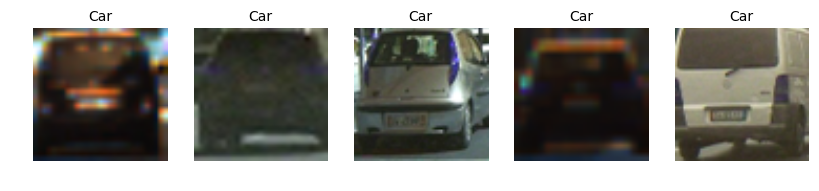

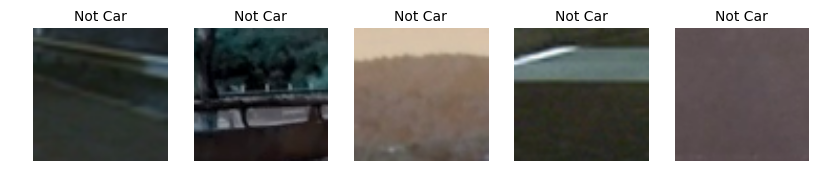

In [6]:
show_samples(cars, "Car")
show_samples(notcars, "Not Car")

### Visualize: Hog Features

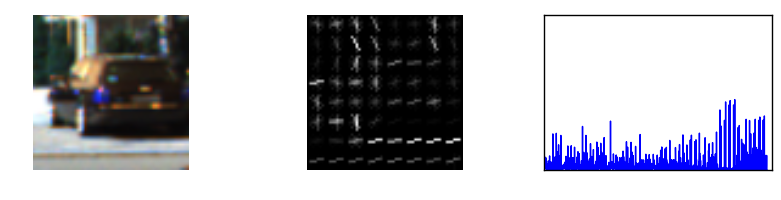

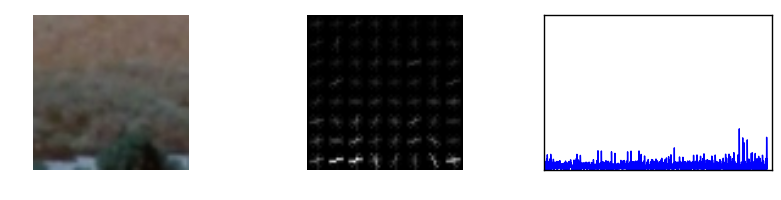

In [7]:
def plot_hog_sample(image, hog_image, hog_features):
    plt.figure(figsize=(10,2))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.plot(hog_features)
    plt.ylim(0,1)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot positive image
image = get_random_image(cars)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = feature_extractor.get_hog_features(gray_image, orient=orient, 
                                           pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, vis=True)
plot_hog_sample(image, hog_image, hog_features)

# plot negative image
image = get_random_image(notcars)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = feature_extractor.get_hog_features(gray_image, orient=orient, 
                                           pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, vis=True)
plot_hog_sample(image, hog_image, hog_features)

### Visualize: Color histogram

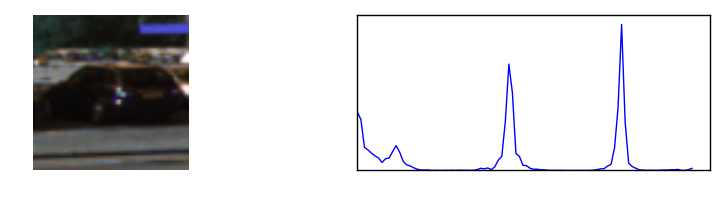

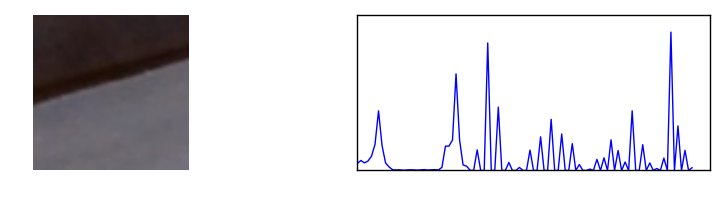

In [8]:
def plot_color_histogram_sample(image, yuv_image):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(feature_extractor.color_hist(yuv_image))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()
    
# plot positive image
image = get_random_image(cars)
yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_color_histogram_sample(image, yuv_image)

# plot negative image
image = get_random_image(notcars)
yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_color_histogram_sample(image, yuv_image)

### Visualize: Binned color

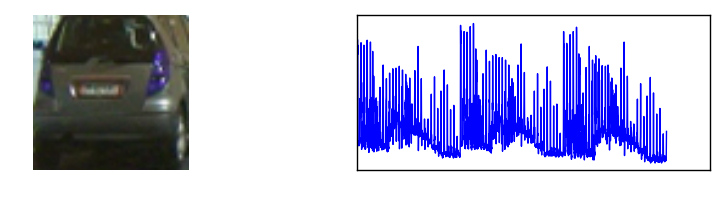

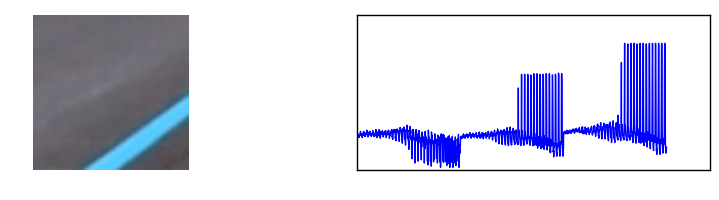

In [9]:
def plot_bin_spatial_sample(image):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(feature_extractor.bin_spatial(image))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot positive image
image = get_random_image(cars)
plot_bin_spatial_sample(image)

# plot negative image
image = get_random_image(notcars)
plot_bin_spatial_sample(image)

### Feature Extraction and Scaling

In [10]:
car_features = feature_extractor.extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("car_features: {} x {}".format(len(car_features), len(car_features[0])))

notcar_features = feature_extractor.extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("notcar_features: {} x {}".format(len(notcar_features), len(notcar_features[0])))

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print("Feature Scaling Complete")

car_features: 8792 x 8460
notcar_features: 9666 x 8460
Feature Scaling Complete


### Save Features and Labels

In [11]:
## save features
fn = GEN_FOLDER + '/features_scaled_X.pkl'
joblib.dump(scaled_X, fn) 

## save labels
fn = GEN_FOLDER + '/labels_y.pkl'
joblib.dump(y, fn)

print("Features and Labels saved")

Features and Labels saved


### Load Features and Labels

In [12]:
# load features
scaled_X = joblib.load(GEN_FOLDER + '/features_scaled_X.pkl') 
y = joblib.load(GEN_FOLDER + '/labels_y.pkl') 

print("Features and Labels loaded")

Features and Labels loaded


### Split Train Test dataset

In [13]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print("X_train:", len(X_train))
print("X_test:", len(X_test))
print("y_train:", len(y_train))
print("y_test:", len(y_test))

X_train: 14766
X_test: 3692
y_train: 14766
y_test: 3692


### Train SVM classifier

In [14]:
import time

print('Using:', orient, 'orientations', pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
predictions = svc.predict(X_test)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
8.84 Seconds to train SVC...
Test Accuracy of SVC =  0.9943


### Metrics and Confusion matrix

In [15]:
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

    plt.title(title+ "\n")
    fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(GEN_FOLDER + '/confusionmatrix.png')

accuracy_score: 0.994312026002
f1_score: 0.994294777903
precision_score: 0.994401757475
recall_score: 0.994195011818


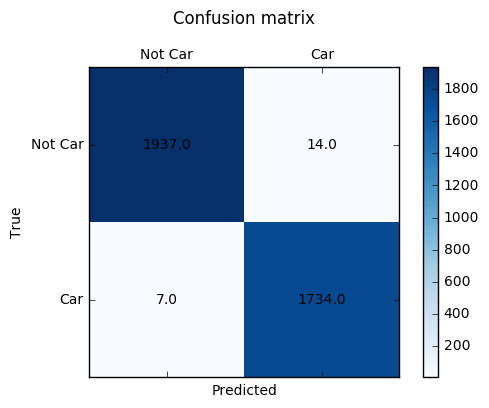

In [16]:
# calculate metrics
print("accuracy_score:", accuracy_score(y_test, predictions))
print("f1_score:", f1_score(y_test, predictions, average="macro"))
print("precision_score:", precision_score(y_test, predictions, average="macro"))
print("recall_score:", recall_score(y_test, predictions, average="macro")) 

# sklearn confusion matrix 
cm = confusion_matrix(predictions, y_test)

# plot using matplotlib
plot_confusion_matrix(cm, labels = ['Not Car', 'Car'])

### Save Model

In [17]:
from sklearn.externals import joblib

## save svc
fn = GEN_FOLDER + '/svc.pkl'
joblib.dump(svc, fn) 

## save x_scaler
fn = GEN_FOLDER + '/x_scaler.pkl'
joblib.dump(X_scaler, fn) 

print('svc, x_scaler saved')

svc, x_scaler saved
